### Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 
### На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.

Я подумал, что реализация конкретных системных действий (типа взять скриншот) - это немного за рамками нашего курса, надо будет придумывать паузы, чтобы одно действие дважды не выполнилось, а с другой стороны это не должно мешать выполнению нескольких действий подряд... короче, я просто в этом не шарю, а время сдачи уже близко, я как-то не успеваю, поэтому я буду просто выводить на экран, какой жест распознался.

Идея будет такая - сначала просто обучить модель на датасете, а затем картинки с камеры приводить к максимально похожему виду, и скармливать их модели. Для этого я собираюсь на первом кадре получить фон, который затем вычитать из последующих кадров.

Вот тут кроется пара моментов, которые идут в разрез с текстом домашнего задания - во-первых, при таком подходе хочется, чтобы камера была зафиксирована и в ней был только жест. От фиксации камеры можно избавиться, вычитая последовательные кадры (первый - фон, второй - кадр с жестом), только между кадрами надо подобрать оптимальную задержку (чтобы фон не успел измениться, а жест успел оказаться в кадре). Но опять же - всё равно хочется, чтобы в кадре из нового был только конкретный жест, так что приходим ко второму моменту - в моей реализации не хочется, чтобы в кадре оказывалось лицо, поэтому, получается, я нагло проигнорировал требование детекции лица.<br>
В идеале было бы найти аналогичную MTCNN модель, которая детектировала на картинке не лицо, а руку (точнее, кисть), но поверхностное гугление не принесло мне ответа, который было бы легко использовать (типа from facenet_pytorch import), поэтому я решил схалтурить используя приведённые выше аргументы.

### Подготовка датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as tt

import time
from sklearn.model_selection import train_test_split

In [2]:
batch_size = 64

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('./leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [78]:
transform = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

# Для использования на изображениях, полученных с камеры
test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [5]:
# К датасету на Каггле есть ноутбук, в котором приведено использование датасета
# с минимальными изменениями это - тот самый код
x_data = []
y_data = []
datacount = 0
for i in range(0, 10):
    for j in os.listdir('./leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        count = 0
        for k in os.listdir('./leapgestrecog/leapGestRecog/0' + 
                            str(i) + '/' + j + '/'):
            img = Image.open('./leapgestrecog/leapGestRecog/0' + 
                             str(i) + '/' + j + '/' + k).convert('LA')
            img = img.resize((320, 120))
            img = transform(img)
            arr = np.array(img)
            x_data.append(arr) 
            count = count + 1
        y_values = np.full((count, 1), lookup[j]) 
        y_data.append(y_values)
        datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1)

In [6]:
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.2)

x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

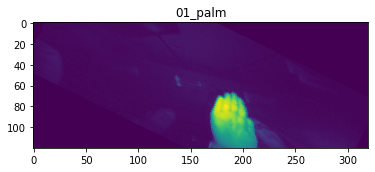

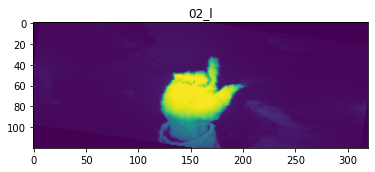

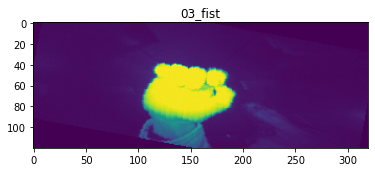

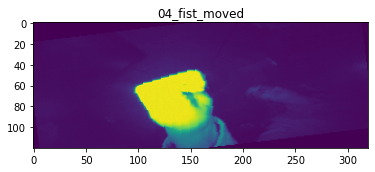

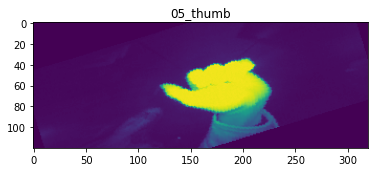

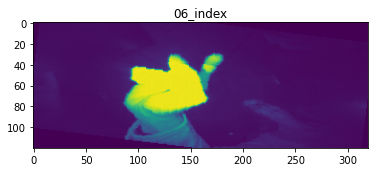

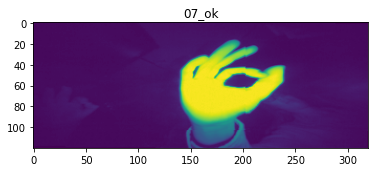

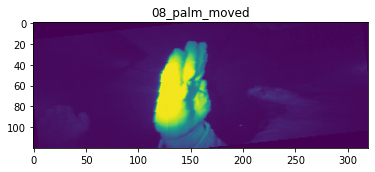

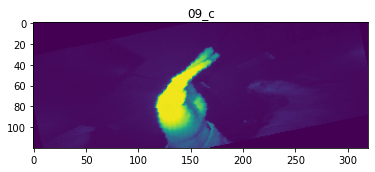

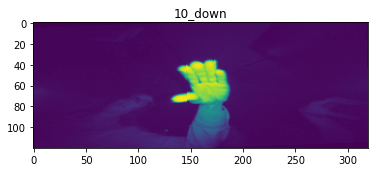

In [8]:
for i in range(0, 10):
    plt.imshow(x_data[i*200 , 0, :, :])
    plt.title(reverselookup[y_data[i*200, 0]])
    plt.show()

### Обучение

In [5]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 32, 5, padding=2)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = self.conv_block(32, 64, 3)
        self.drop2 = nn.Dropout(0.5)
        self.conv3 = self.conv_block(64, 64, 3)
        self.drop3 = nn.Dropout(0.5)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(38400, num_classes)
    
    @staticmethod
    def conv_block(in_channels, out_channels, kernel_size, padding=1, pool=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.drop3(out)
        
        out = self.flatten(out)
        out = self.linear(out)
        return out

In [6]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [7]:
device = get_default_device()
device

device(type='cpu')

In [40]:
model = to_device(Net(1, len(lookup)), device)

In [41]:
epochs = 5
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

loss_func = nn.CrossEntropyLoss()

In [42]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [43]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
        data = data.to(device)
        labels = labels.long()
        labels = labels.to(device)
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = loss_func(outputs, labels.squeeze_())
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 1000 == 999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/1000}')
            time2 = time.time()
            print(f'Spend time for 1000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  2.2159356129169465
Epoch 2, loss:  1.19727425467968
Epoch 3, loss:  0.544519627392292
Epoch 4, loss:  0.27701004848629235
Epoch 5, loss:  0.15132121488451958


In [44]:
torch.save(model.state_dict(), './models/model1.pth')

### Пример работы модели

<ipython-input-45-94bd24d46f7e>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)


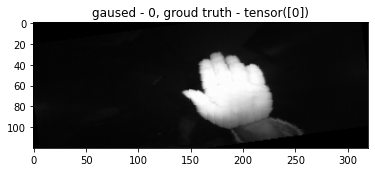

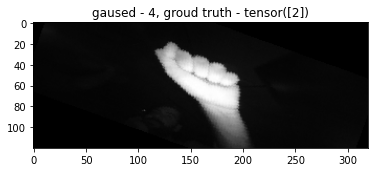

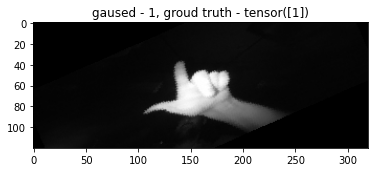

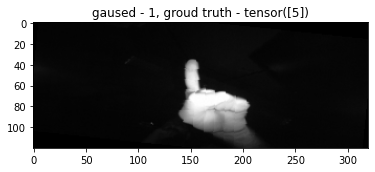

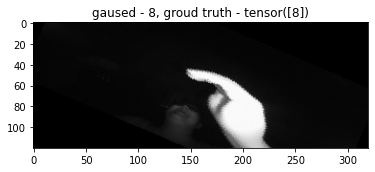

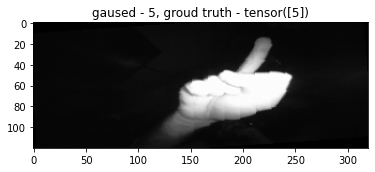

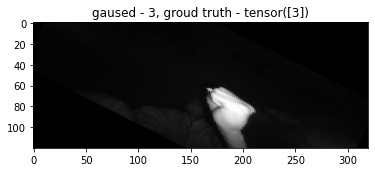

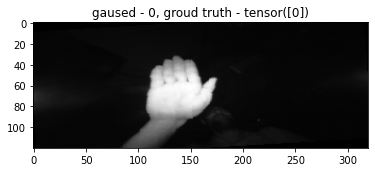

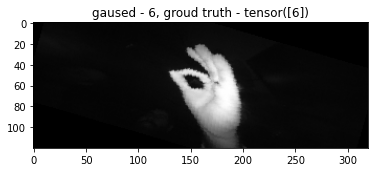

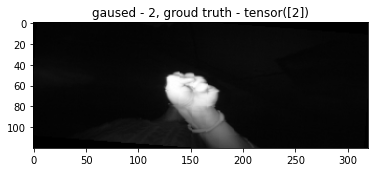

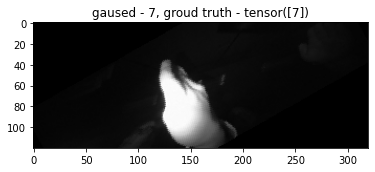

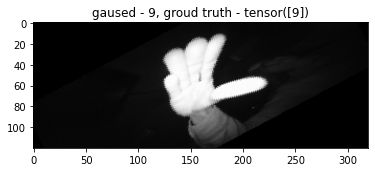

In [45]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        labels = labels.long()
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = model(images)
        plt.title(f'gaused - {(outputs[0].argmax())}, groud truth - {(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

### Вторая часть - работа с картинками с камеры

In [8]:
# Делал в другой день, поэтому модель загружаем из файла
model=Net(1, len(lookup)).to(device)
model.load_state_dict(torch.load('./models/model1.pth'))
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop2): Dropout(p=0.5, inplace=False)
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [9]:
import cv2

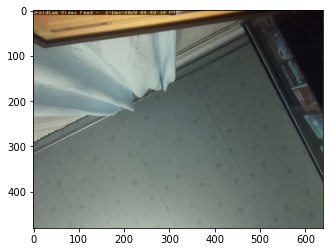

In [101]:
# Камеру расположил самым продуманным образом, чтобы ничего не мешало на заднем плане!
# На деле - я подключил телефон в качестве камеры с помощью приложения DroidCam
# телефон просто лежит на столе и смотрит в потолок
cap = cv2.VideoCapture("http://192.168.1.243:4747/video")
ret, frame = cap.read()
if ret:
    plt.imshow(frame)
cap.release()

In [57]:
# Функция, которая убирает фон из кадра
def remove_background(frame, bgModel):
    fgmask = bgModel.apply(frame, learningRate=0)
    kernel = np.ones((3, 3), np.uint8)
    fgmask = cv2.erode(fgmask, kernel, iterations=1)
    res = cv2.bitwise_and(frame, frame, mask=fgmask)
    return res

In [95]:
# Функция, которая подготавливает кадр для скармливания модели
def process_frame(frame):
    PIL_image = Image.fromarray(frame.astype('uint8'), 'RGB')
    image_from_camera = torch.Tensor([np.array(test_transforms(PIL_image.convert('LA').resize((320, 120))))])
    res = model(image_from_camera)
    idx = res[0].argmax().item()
    return idx

In [98]:
# Основной цикл - по кнопкe q производится выход из программы
def run():
    cap = cv2.VideoCapture("http://192.168.1.243:4747/video")
    
    # Первый кадр считаем фоном
    ret, frame = cap.read()
    bgModel = cv2.createBackgroundSubtractorMOG2(0, 50)
    
    last_res = -1
    
    # Заходим в бесконечный цикл
    while True:
        # Считываем каждый новый кадр - frame
        # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
        ret, frame = cap.read()
        try:
            frame = remove_background(frame, bgModel)
            model_res = process_frame(frame)
            # Проверяем, что было изменения жеста - не надо много раз подряд выводить одно и то же
            if last_res != model_res:
                last_res = model_res
                print(reverselookup[model_res])

        except:
            print('Something wrong im main cycle!')
            
        cv2.imshow('Face Detection', frame)

        # Функция, которая проверяет нажатие на клавишу 'q'
        # Если нажатие произошло - выход из цикла. Конец работы приложения
        # Так же я вывожу последний кадр с камеры
        if cv2.waitKey(1) & 0xFF == ord('q'):
            plt.imshow(frame)
            break

    # Очищаем все объекты opencv, что мы создали
    cap.release()
    cv2.destroyAllWindows()
    return frame

01_palm
08_palm_moved
03_fist
10_down
08_palm_moved
10_down
08_palm_moved
03_fist
02_l
09_c
03_fist
10_down
07_ok
10_down
07_ok
10_down
07_ok
10_down
07_ok
10_down
07_ok
09_c
04_fist_moved
03_fist
02_l
10_down
07_ok
10_down
07_ok
10_down
07_ok


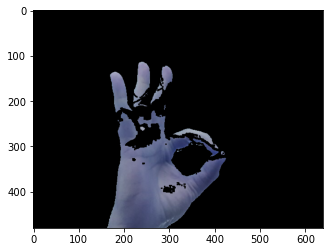

In [100]:
frame = run()